In [1]:
%load_ext autoreload
%matplotlib inline

In [8]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import helpfunction as helper

In [3]:
%autoreload

In [23]:
outdir= './output/FlashHypo/'
inputdir = './input/'  

nrPMT = 32
rangePMT = range(nrPMT)

sample_names = ['nue','nu','on','off']
file_names = [next((s for s in os.listdir(inputdir) if "NueCC_"+sample+"_" in s), None) for sample in sample_names]
print(file_names)
str_ = "MCC9 November: "
sample_names_title = dict(zip(sample_names, [r"Intrinsic $\nu_e$", r"BNB $\nu$", r"BNB on (4.4e19)", r"BNB off (data)"]))

['NueCC_nue_mcc9_nov.root', 'NueCC_nu_mcc9_nov.root', 'NueCC_on_mcc9_nov.root', 'NueCC_off_mcc9_nov.root']


In [5]:
def search_unsorted(index_large, values_large, index_subset):
    if (len(index_large)!=len(values_large)):
        return -1
    sorter = np.argsort(index_large)
    return values_large[sorter][np.searchsorted(index_large[sorter], index_subset)]

In [6]:
file_flashes = {}
file_slices = {}
file_events = {}
for i, (idx, fn) in enumerate(zip(sample_names, file_names)):
    file_flashes[idx] = uproot.open(inputdir+fn)['pandoraFlashEventBuilding/flashes']
    file_slices[idx] = uproot.open(inputdir+fn)['pandoraFlashEventBuilding/slices']
    file_events[idx] = uproot.open(inputdir+fn)['pandoraFlashEventBuilding/events']

### 2(H-O)/(H+O)-plot

In [9]:
this_sample = "nue"
f_flashes = file_flashes[this_sample]
f_slices = file_slices[this_sample]

flash_ids = f_flashes.array("evt_time_nsec")
flash_pes = f_flashes.array("peSpectrum")

slice_purity = f_slices.array("purity")>0.8
slice_completeness = f_slices.array("completeness")>0.8
slice_hypos = f_slices.array("peHypothesisSpectrum")
slice_flashmatched = (slice_hypos.counts==32) & (slice_hypos.sum()>0.0)
slice_mask = slice_purity & slice_completeness & slice_flashmatched
slice_ids = f_slices.array("evt_time_nsec")[slice_mask]
slice_hypos = np.array(slice_hypos[slice_mask])

In [10]:
slice_pe = np.array(search_unsorted(flash_ids, flash_pes, slice_ids))

# 2(H-O)/(H+O)
a = 2*(slice_hypos-slice_pe)
b = (slice_hypos+slice_pe)
y_vals = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
mask = (slice_hypos<10) & (slice_pe<10)
y_vals[mask]=-3

In [11]:
y = np.nan_to_num(y_vals).T.flatten()
x = np.repeat(range(32),len(y_vals))
print(len(x), len(y))

1569376 1569376


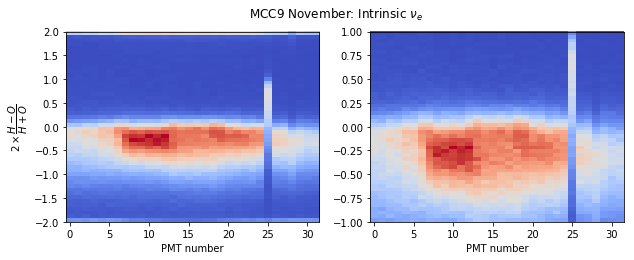

In [12]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,3.5))

ax[0].hist2d(x,y, range=((-0.5,31.5),(-2,2)), bins=(32,50), cmap="coolwarm")
ax[1].hist2d(x,y, range=((-0.5,31.5),(-1,1)), bins=(32,50), cmap="coolwarm")
ax[0].set_ylabel(r"$2 \times \dfrac{H-O}{H+O}$")
ax[0].set_xlabel(r"PMT number")
ax[1].set_xlabel(r"PMT number")

fig.suptitle(str_+sample_names_title[this_sample])
fig.savefig(outdir+"nu.pdf", bbox_inches='tight')

(array([    0., 29879.,     0.,   856.,  2249.,  6382.,  7703.,   603.,
          210.,  1161.]),
 array([-4. , -3.4, -2.8, -2.2, -1.6, -1. , -0.4,  0.2,  0.8,  1.4,  2. ]),
 <a list of 10 Patch objects>)

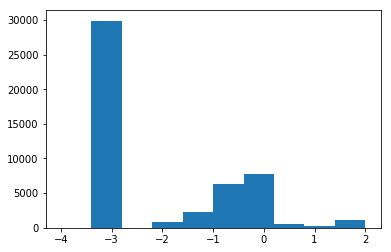

In [13]:
pmt0 = list(np.nan_to_num(y_vals).T[0])
plt.hist(pmt0, range=(-4,2))

### Single flash event viewer

The combination of event, subrun and run was found 3 times in the sample.
Taking the first one...

Run 1 , Subrun 560 , Event 11184  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 1
hasBeamFlash :	 True
nSlices :	 6
nSlicesAfterPrecuts :	 1
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 0.5761997
leptonEnergy :	 0.22734629
nuInteractionTime :	 4055.5508
nuPdgCode :	 12
nuVertexX :	 121.71733
nuVertexY :	 19.540274
nuVertexZ :	 861.0828

--- FLASH INFO ---
time :	 [4.11125]
centerY :	 [4.573296]
centerZ :	 [849.29755]
widthY :	 [43.513718]
widthZ :	 [116.45979]
totalPE :	 [879.618]
inBeamWindow :	 [ True]
isBeamFlash :	 [ True]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True  True  True]
totalCharge :	 [47281.836 14399.018 16068.805 19996.244 24022.13   5036.902]
centerX :	 [ 69.34565  242.95416   11.676647 194.6139   131.31163   82.69796 ]
centerY :	 [ 33.411766  60.178143  88.49612  -76.13153   28.419115 104.39034 ]
centerZ :	 [983.3183   367.

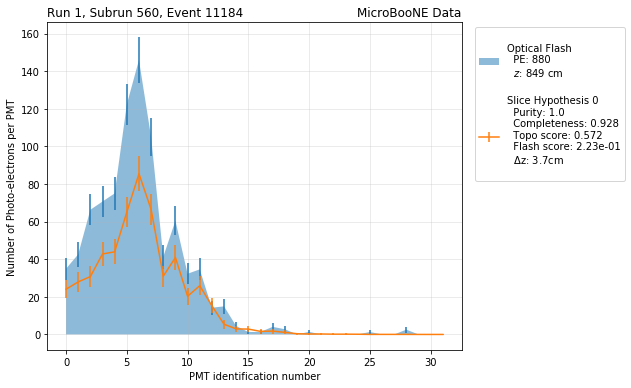

In [14]:
sample = "nue"
run = 1
subrun = 560
event = 11184

sample_dict = {'events': file_events[sample],
               'flashes': file_flashes[sample],
               'slices': file_slices[sample]
              }

helper.SingleEventViewer(run,subrun,event, sample_dict, save_plot=True)

### Plots about the PE per PMT

In [56]:
# Save the PE values of beam flashes in a seperate numpy array:
# For the rolling sample, We only want to compare the PE rates with the run3/4 part
# https://microboone-exp.fnal.gov/at_work/AnalysisTools/data/ub_datasets_optfilter.html

#sample_names = ['nue','nu','on','off']
#file_flashes

#scales = [scale_nue, scale_nu, scale_on, scale_off]
scales = [0.0009510529046483252, 0.22770676408583113, 1, 1.00680224314536]

df_pe = []
for f,s,w in zip(file_flashes, sample_names,scales):
    pes = np.array(file_flashes[s].array("peSpectrum"))
    pes = pes.astype(float)
    print(len(pes))
    df = pd.DataFrame(pes)
    df['weight'] = w
    df['sample'] = s
    df_pe.append(df)
df_pe = pd.concat(df_pe)

109126
172905
186151
138517


In [57]:
cols = ["PMT"+str(i) for i in rangePMT]
cols.extend(df_pe.columns[-2:])
df_pe.columns = cols
df_pe.head()

,PMT0,PMT1,PMT2,PMT3,PMT4,PMT5,PMT6,PMT7,PMT8,PMT9,...,PMT24,PMT25,PMT26,PMT27,PMT28,PMT29,PMT30,PMT31,weight,sample
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024048,0.798824,0.640602,2.047330,...,141.922195,56.168716,75.285088,116.423477,83.902702,56.255856,48.213470,50.994942,0.000951,nue
1,2.455952,0.740861,3.813092,2.041976,6.078815,3.242129,8.804198,9.947119,33.005543,20.730446,...,3.094213,1.787445,0.000000,0.000000,1.356349,1.390040,0.588577,0.000000,0.000951,nue
2,1.987677,0.000000,0.597262,5.955972,2.668046,1.207440,6.689333,17.978436,34.132591,25.045336,...,7.902200,2.486597,2.050595,3.361289,3.879613,0.000000,0.000000,0.000000,0.000951,nue
3,34.942471,42.577774,66.298294,70.684105,75.002785,122.306229,145.950867,104.935471,41.305714,60.452641,...,0.000000,1.307680,0.000000,0.000000,2.555000,0.000000,0.000000,0.000000,0.000951,nue
4,0.000000,0.000000,0.562284,1.453095,0.000000,0.641837,0.000000,0.000000,0.000000,0.627610,...,22.210812,15.852911,27.346157,16.404819,27.278139,20.154463,17.912598,9.384562,0.000951,nue


In [63]:
means = df_pe.groupby(['sample']).mean()
print(means)

             PMT0       PMT1       PMT2       PMT3       PMT4       PMT5  \
sample                                                                     
nu      37.799708  38.434379  39.524885  39.859763  42.689832  43.246456   
nue     66.967654  67.915309  70.053275  71.344687  75.685324  77.242602   
off     45.375617  41.434313  43.553608  45.700925  58.555436  41.857228   
on      44.830279  40.627566  41.613934  45.026791  55.565862  41.401861   

             PMT6       PMT7       PMT8       PMT9    ...         PMT23  \
sample                                                ...                 
nu      50.102848  50.223091  45.803936  45.826816    ...     43.886678   
nue     90.822479  91.787507  81.117490  82.665028    ...     83.243575   
off     39.497527  63.385328  39.001262  74.113670    ...     41.769461   
on      38.783196  62.651384  38.367814  72.924408    ...     41.962268   

            PMT24      PMT25      PMT26      PMT27      PMT28      PMT29  \
sample          

In [69]:
df = means.transpose()
df.drop(df.tail(1).index,inplace=True)

Text(0,0.5,'Photo-electrons')

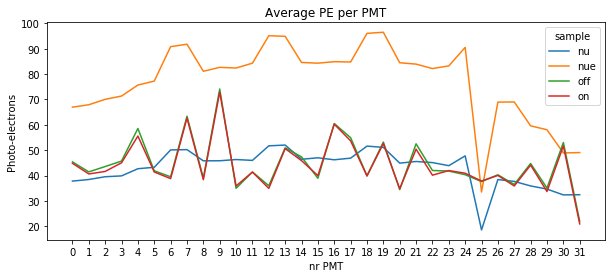

In [75]:
ax = df.plot(title='Average PE per PMT', xticks=rangePMT, figsize=(10,4))
ax.set_xticklabels(rangePMT)
ax.set_xlabel("nr PMT")
ax.set_ylabel("Photo-electrons")